In [1]:
import os
import pyabf
import matplotlib.pyplot as plt
import numpy as np


#### Configuring paths and variables

In [2]:
abf_file_path = os.path.abspath("./HH180618_0001.abf")      # axon-soma rec
abf_metadata = {'recording_name':'HH180618_0001', 'ch_soma_voltage':2, 'ch_soma_current':3, 'ch_axon_voltage':0, 'ch_soma_voltage_name':'Channel Adc5', 'stim_start':0.12355, 'stim_end':1.12342, 'stim_amps':[]}

save_dir_figs = os.path.abspath(f"./Figures/{abf_metadata['recording_name']}")
if not os.path.exists(save_dir_figs):
    os.makedirs(save_dir_figs)
    
save_dir_data = os.path.abspath(f"./KOKI_format/{abf_metadata['recording_name']}")
if not os.path.exists(save_dir_data):
    os.makedirs(save_dir_data)
    
plot_figures = False
save_figures = True

#### Load the ABF file

In [3]:
abf = pyabf.ABF(abf_file_path)
print("Loaded file: %s" % abf)
num_sweeps = abf.sweepCount
print("Number of sweeps:", num_sweeps)

Loaded file: ABF (v1.83) with 4 channels (mV, pA, mV, pA), sampled at 100.0 kHz, containing 14 sweeps, having no tags, with a total length of 0.38 minutes, recorded with protocol "HH_IV_I to Multi CH2".
Number of sweeps: 14


#### Calculating the stim amplitudes

In [4]:
if not abf_metadata['stim_amps']:
    print('Sampling frequency:', abf.sampleRate)
    abf_metadata['samp_freq'] = abf.sampleRate
    stim_start = int(abf_metadata['stim_start']*abf_metadata['samp_freq'])
    stim_end = int(abf_metadata['stim_end']*abf_metadata['samp_freq'])
    #print(stim_start)
    #print(stim_end)
    
    for sweep in range(num_sweeps):
        abf.setSweep(sweep, channel=abf_metadata['ch_soma_current'])
        stim_amp = round(np.mean(abf.sweepY[stim_start:stim_end]), 4)
        stim_amp_sd = round(np.std(abf.sweepY[stim_start:stim_end]), 4)
        abf_metadata['stim_amps'].append({'value':stim_amp, 'sd':stim_amp_sd})   
    
    print('Stim amps:', abf_metadata['stim_amps'])

else:
    print('Stim amplitudes already calculated')
    print('Stim amps:', abf_metadata['stim_amps'])

Sampling frequency: 100000
Stim amps: [{'value': -304.2909, 'sd': 0.8601}, {'value': -203.2028, 'sd': 0.8587}, {'value': -102.2751, 'sd': 0.8535}, {'value': -1.2564, 'sd': 0.9027}, {'value': 100.0187, 'sd': 0.8535}, {'value': 200.8003, 'sd': 0.8483}, {'value': 301.8071, 'sd': 0.8562}, {'value': 404.1948, 'sd': 0.864}, {'value': 504.8796, 'sd': 0.8554}, {'value': 606.108, 'sd': 0.8568}, {'value': 706.8994, 'sd': 0.8662}, {'value': 807.729, 'sd': 0.8594}, {'value': 908.8123, 'sd': 0.8584}, {'value': 1009.7493, 'sd': 0.8723}]


### Converting to KOKI format


#### Creating the protocol file

In [12]:
path_protocol = os.path.join(save_dir_data, 'protocol.txt')

stim_amps_final = ' '.join(str(x) for x in range(-300, 1001, 100))
print(stim_amps_final)

with open(path_protocol, 'w') as protocol_file:
    protocol_file.write(abf.protocol + "\n") 
    protocol_file.write(f"ch{abf_metadata['ch_soma_voltage'] + 1}\n") 
    protocol_file.write(str(abf_metadata['samp_freq']) + "\n") 
    protocol_file.write(str(abf_metadata['stim_start']*1000) + " " + str(abf_metadata['stim_end']*1000) + " " + str(abf.sweepLengthSec*1000) + "\n")
    #protocol_file.write(' '.join([str(entry['value']) for entry in abf_metadata['stim_amps']]) + "\n")
    protocol_file.write(stim_amps_final + "\n")
    protocol_file.write(f"axon voltage: ch{abf_metadata['ch_axon_voltage'] + 1}")    
    
print(protocol_file)


-300 -200 -100 0 100 200 300 400 500 600 700 800 900 1000
<_io.TextIOWrapper name='C:\\Users\\Bogi\\Documents\\KOKI\\PVBC_models_evaluation\\Hu_adatok\\Files\\KOKI_format\\HH180618_0001\\protocol.txt' mode='w' encoding='cp1250'>


#### Creating the KOKI format soma current data txt

In [6]:
path_voltage_data = os.path.join(save_dir_data, f"{abf_metadata['recording_name']}_ch{abf_metadata['ch_soma_current']+1}.txt")

soma_current_response_lists = []
for sweep in range(num_sweeps):
    abf.setSweep(sweep, channel=abf_metadata['ch_soma_current'])
    soma_current_response_lists.append(abf.sweepY)

transposed_lists = zip(*soma_current_response_lists)    # transpose the lists
        
column_width = 20
with open(path_voltage_data, 'w') as file:
    for row in transposed_lists:
        # Format each value with the specified width and align to the right
        formatted_row = [f"{value:>{column_width}}" for value in row]
        # Join the formatted values with tabs and write the row to the file
        file.write('\t'.join(formatted_row) + '\n')
        

#### Creating the KOKI format soma voltage data txt

In [7]:
path_voltage_data = os.path.join(save_dir_data, f"{abf_metadata['recording_name']}_ch{abf_metadata['ch_soma_voltage']+1}.txt")

soma_voltage_response_lists = []
for sweep in range(num_sweeps):
    abf.setSweep(sweep, channel=abf_metadata['ch_soma_voltage'])
    soma_voltage_response_lists.append(abf.sweepY)

transposed_lists = zip(*soma_voltage_response_lists)    # transpose the lists

column_width = 20
with open(path_voltage_data, 'w') as file:
    for row in transposed_lists:
        # Format each value with the specified width and align to the right
        formatted_row = [f"{value:>{column_width}}" for value in row]
        # Join the formatted values with tabs and write the row to the file
        file.write('\t'.join(formatted_row) + '\n')

#### Creating the KOKI format axon voltage data txt

In [8]:
path_voltage_data = os.path.join(save_dir_data, f"{abf_metadata['recording_name']}_ch{abf_metadata['ch_axon_voltage']+1}.txt")

axon_voltage_response_lists = []
for sweep in range(num_sweeps):
    abf.setSweep(sweep, channel=abf_metadata['ch_axon_voltage'])
    axon_voltage_response_lists.append(abf.sweepY)

transposed_lists = zip(*axon_voltage_response_lists)    # transpose the lists

column_width = 20
with open(path_voltage_data, 'w') as file:
    for row in transposed_lists:
        # Format each value with the specified width and align to the right
        formatted_row = [f"{value:>{column_width}}" for value in row]
        # Join the formatted values with tabs and write the row to the file
        file.write('\t'.join(formatted_row) + '\n')
        

#### Calculating the mean soma current and voltage outside the stimulus

[{'value': -1.5, 'std': 0.88}, {'value': -1.4, 'std': 0.92}, {'value': -1.27, 'std': 0.91}, {'value': -1.35, 'std': 0.92}, {'value': -1.31, 'std': 0.91}, {'value': -1.34, 'std': 0.92}, {'value': -1.25, 'std': 0.91}, {'value': -1.32, 'std': 0.92}, {'value': -1.26, 'std': 0.9}, {'value': -1.3, 'std': 0.93}, {'value': -1.25, 'std': 0.91}, {'value': -1.3, 'std': 0.92}, {'value': -1.26, 'std': 0.89}, {'value': -1.28, 'std': 0.93}, {'value': -1.25, 'std': 0.92}, {'value': -1.35, 'std': 0.92}, {'value': -1.26, 'std': 0.9}, {'value': -1.39, 'std': 0.92}, {'value': -1.28, 'std': 0.91}, {'value': -1.36, 'std': 0.93}, {'value': -1.24, 'std': 0.9}, {'value': -1.33, 'std': 0.93}, {'value': -1.26, 'std': 0.9}, {'value': -1.35, 'std': 0.92}, {'value': -1.29, 'std': 0.9}, {'value': -1.37, 'std': 0.92}, {'value': -1.29, 'std': 0.9}, {'value': -1.36, 'std': 0.92}]
Mean amplitude of the current BEFORE stim: -1.28
Mean amplitude of the current AFTER stim: -1.34
Overall mean and std of the outside-stimulus

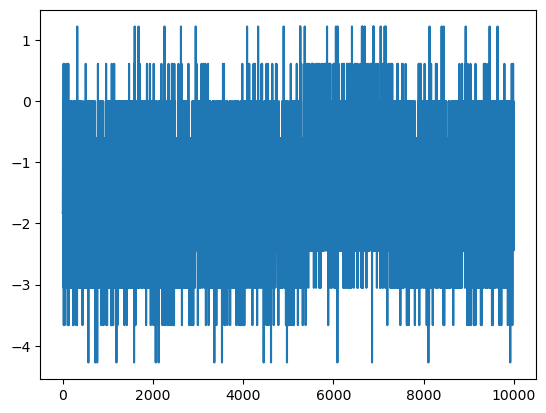

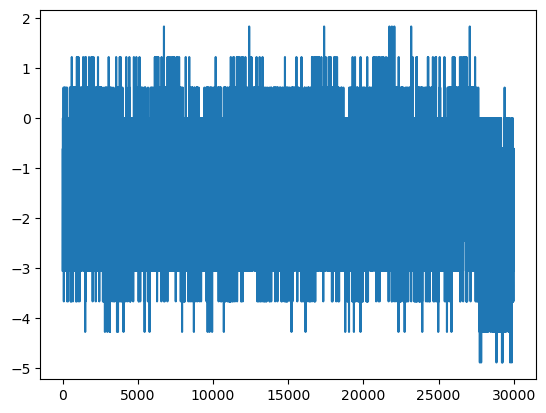

In [9]:
outside_stim_before = int(0.1*abf_metadata['samp_freq'])
outside_stim_after = int(1.2*abf_metadata['samp_freq'])
outside_stim_current_means = []
before_stim_current_means = []
after_stim_current_means = []

for i in range(num_sweeps):
    # before stim
    mean_no_stim_current = round(np.mean(soma_current_response_lists[i][0:outside_stim_before]), 2)
    std_no_stim_current = round(np.std(soma_current_response_lists[i][0:outside_stim_before]), 2)
    before_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    outside_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    # after stim
    mean_no_stim_current = round(np.mean(soma_current_response_lists[i][outside_stim_after:]), 2)
    std_no_stim_current = round(np.std(soma_current_response_lists[i][outside_stim_after:]), 2)
    after_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    outside_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    

print(outside_stim_current_means)
print('Mean amplitude of the current BEFORE stim:', round(np.mean([d['value'] for d in before_stim_current_means]), 2))
print('Mean amplitude of the current AFTER stim:', round(np.mean([d['value'] for d in after_stim_current_means]), 2))
print('Overall mean and std of the outside-stimulus current:', round(np.mean([d['value'] for d in outside_stim_current_means]), 2), round(np.std([d['value'] for d in outside_stim_current_means]), 2))

# Plot an example
plt.figure()
plt.plot(range(0,len(soma_current_response_lists[0][0:outside_stim_before])), soma_current_response_lists[0][0:outside_stim_before])
plt.show()
plt.figure()
plt.plot(range(0,len(soma_current_response_lists[0][outside_stim_after:])), soma_current_response_lists[0][outside_stim_after:])
plt.show()

#### Plot and save figures if needed

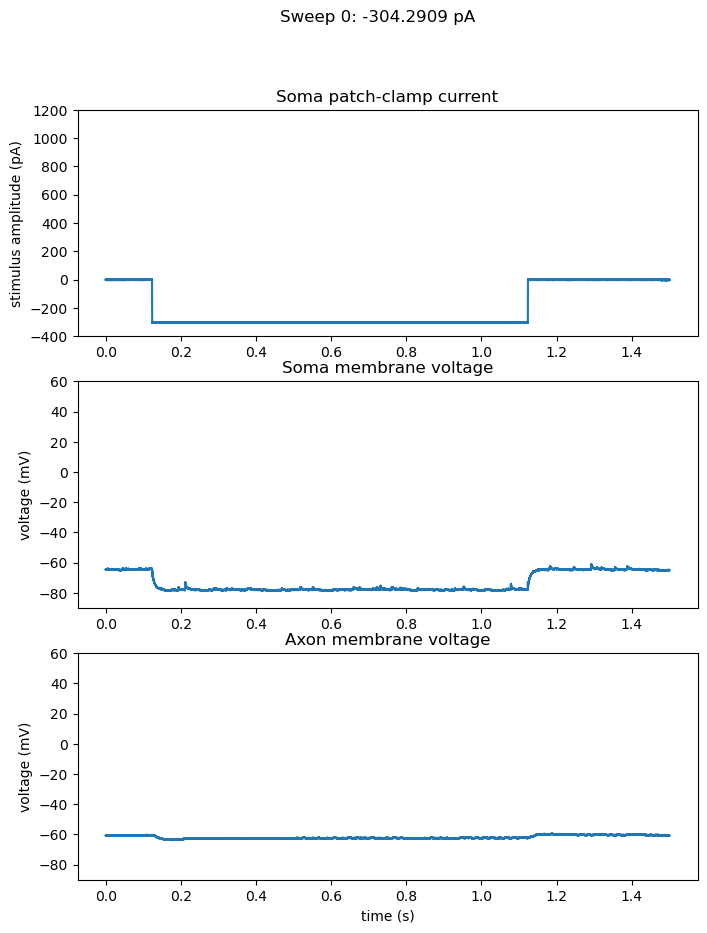

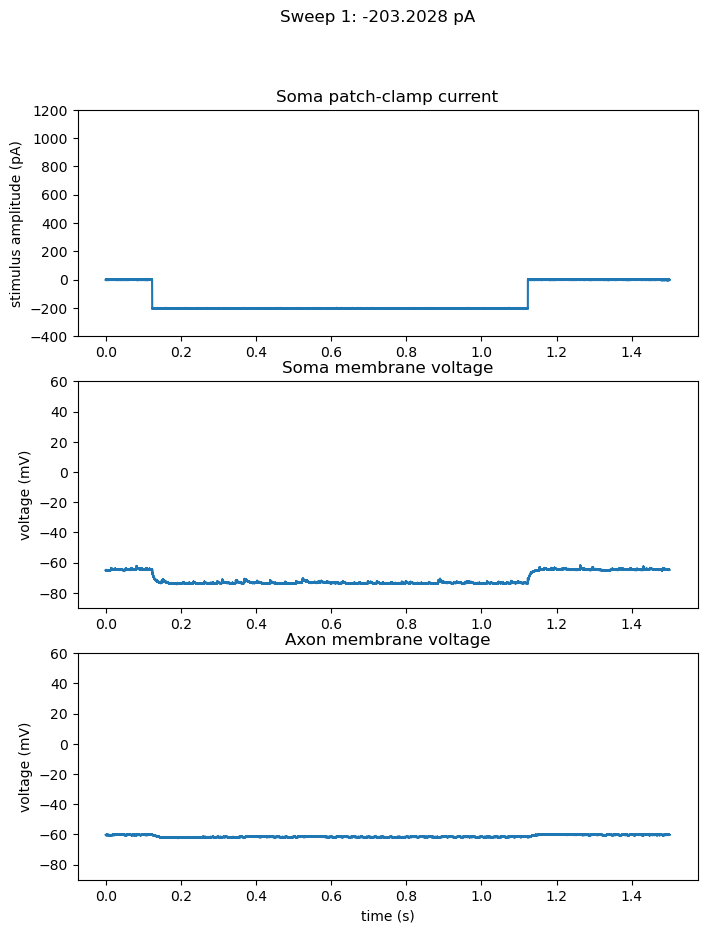

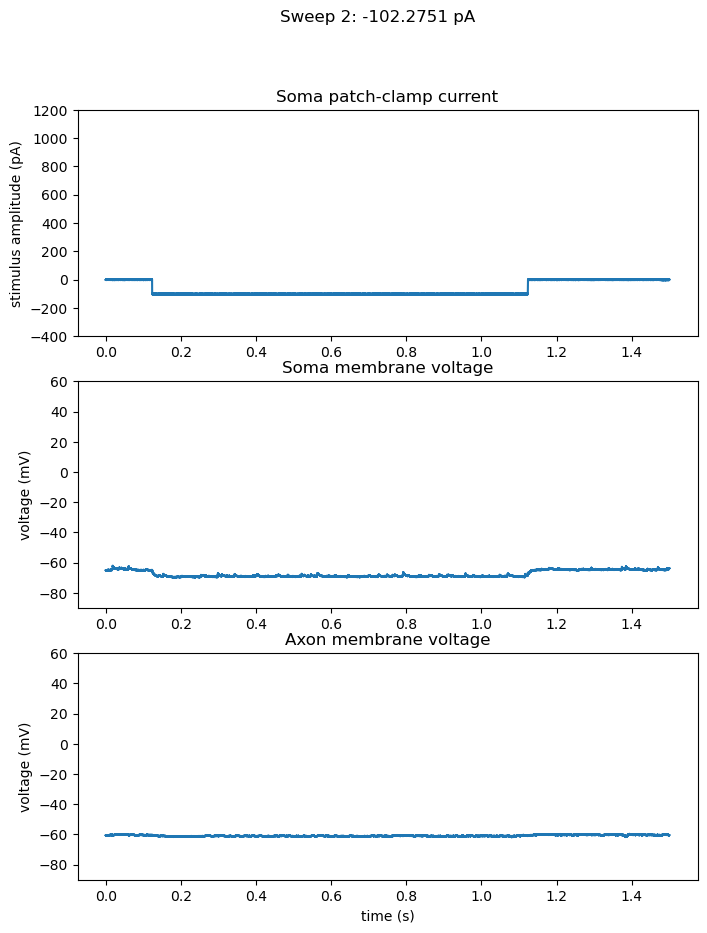

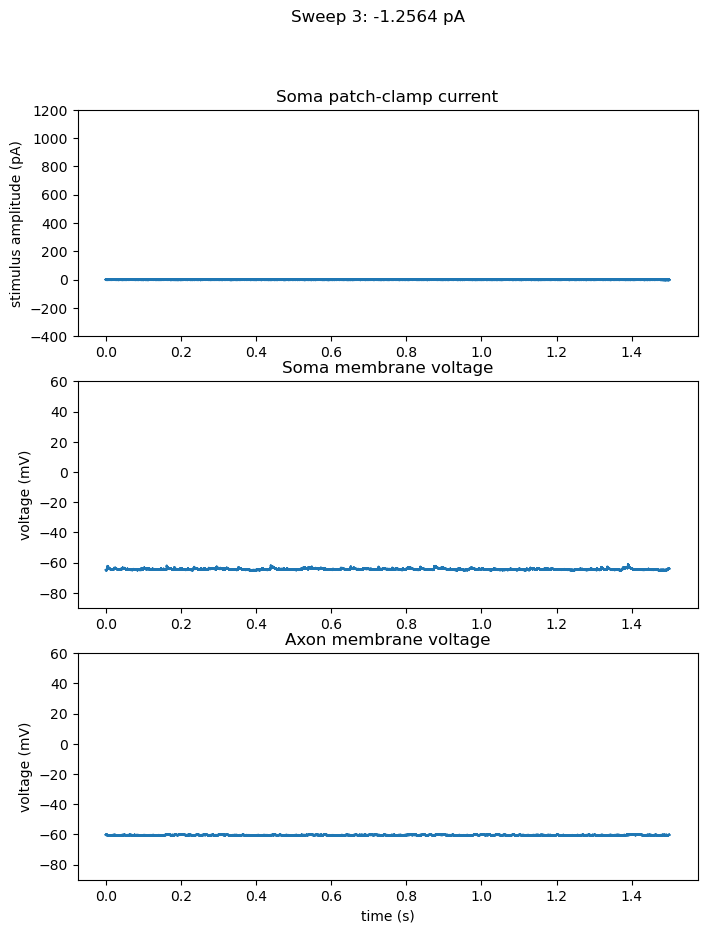

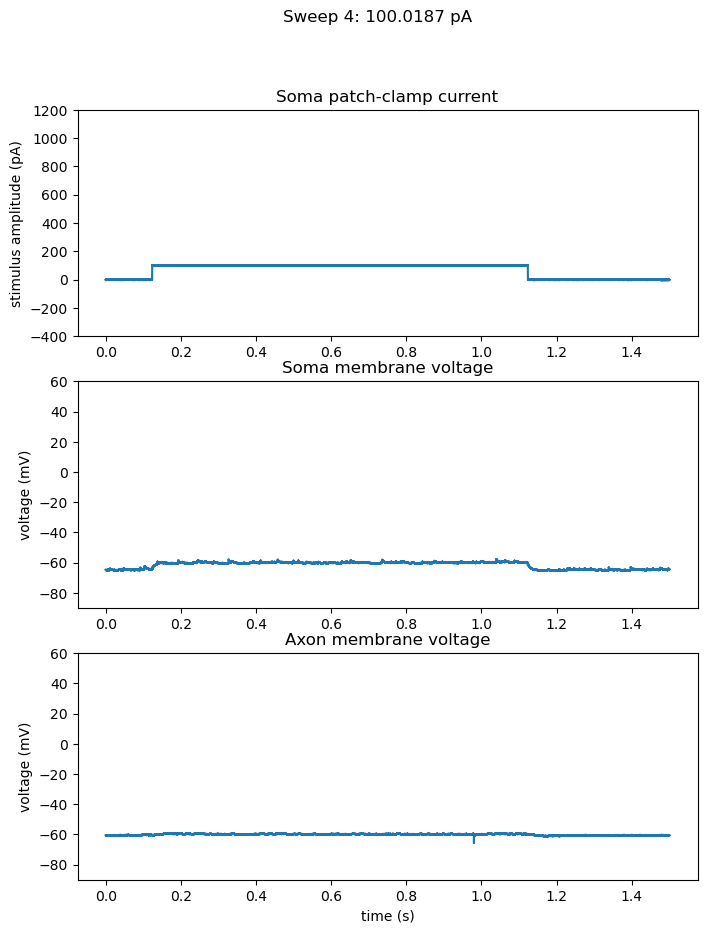

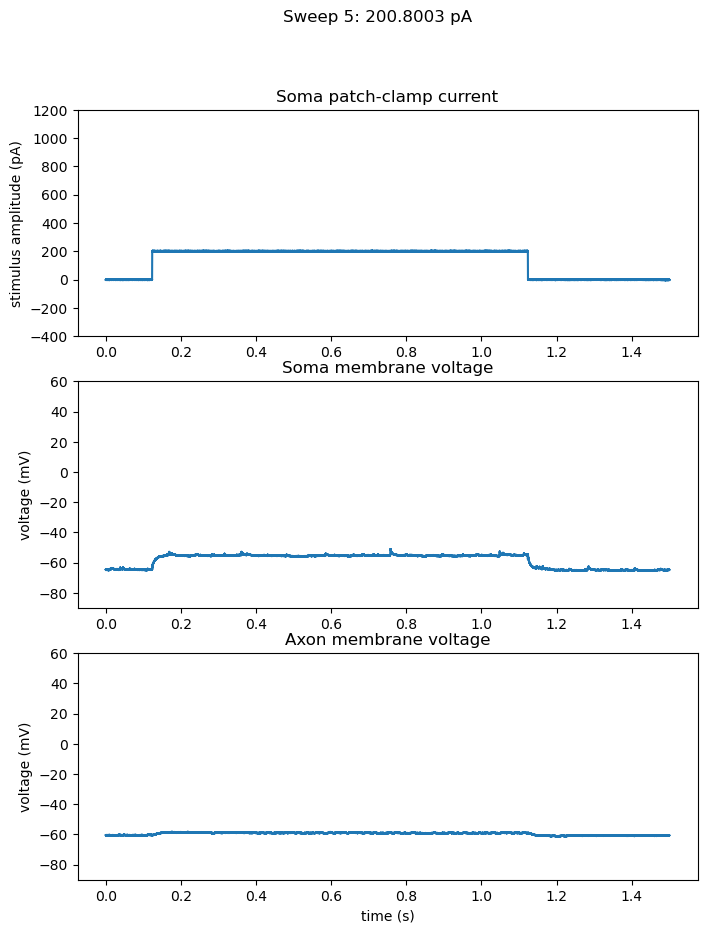

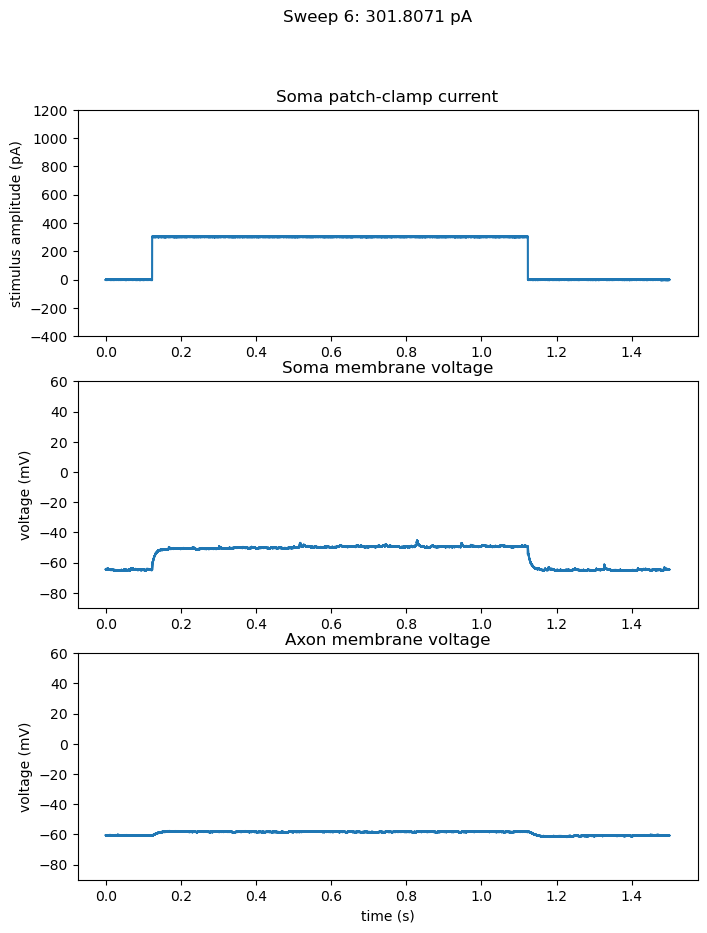

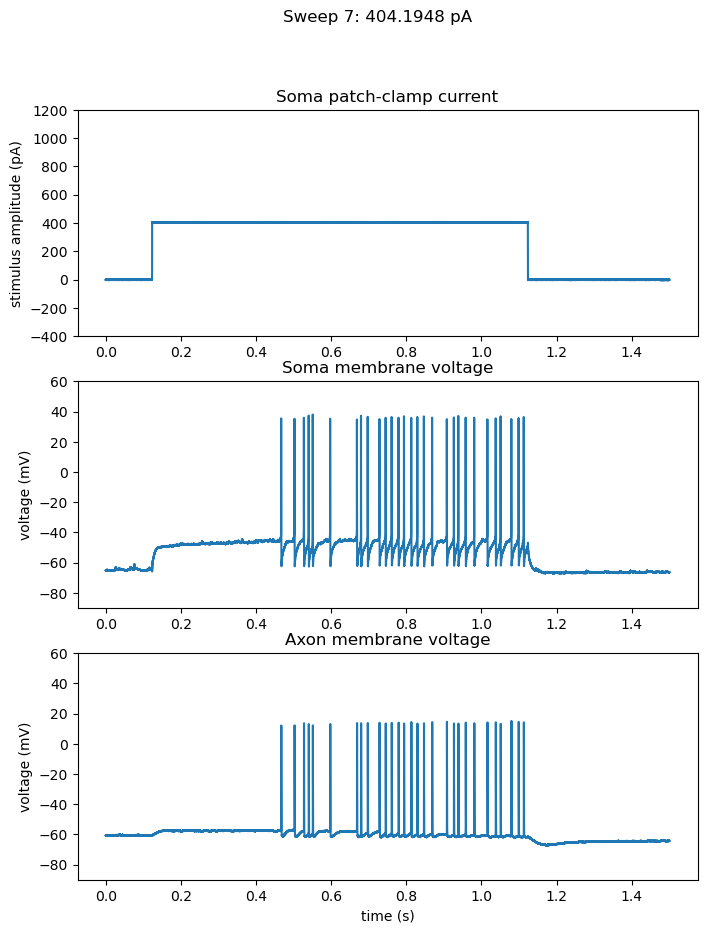

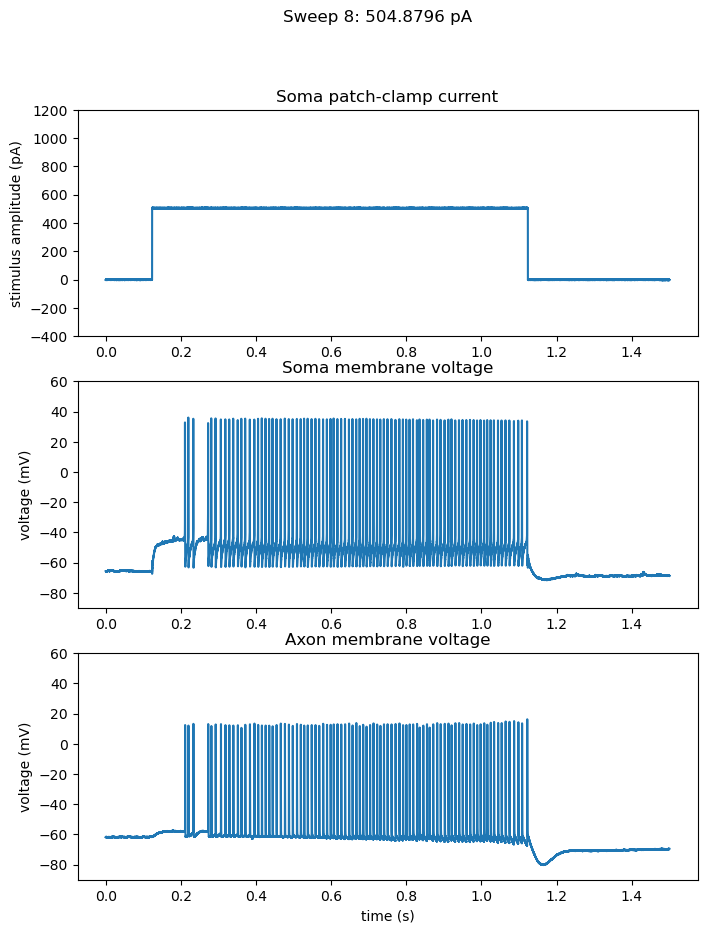

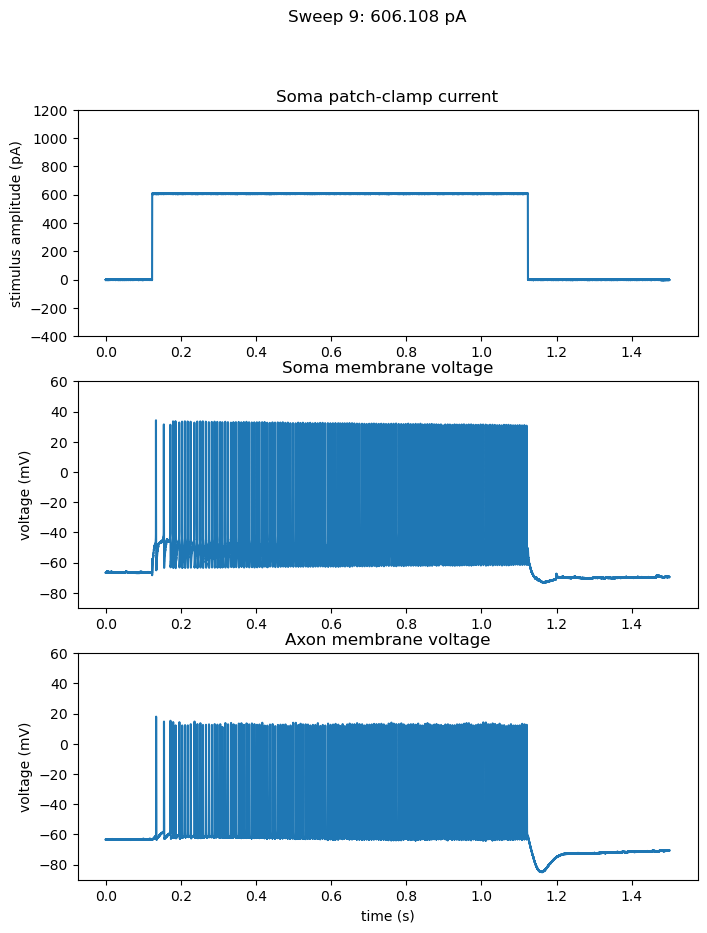

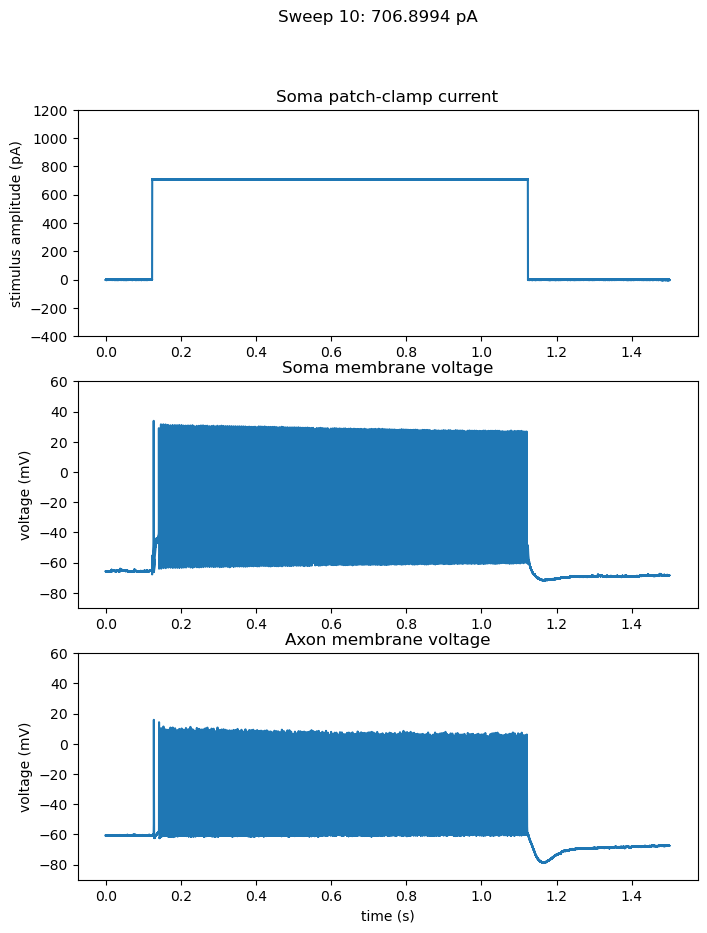

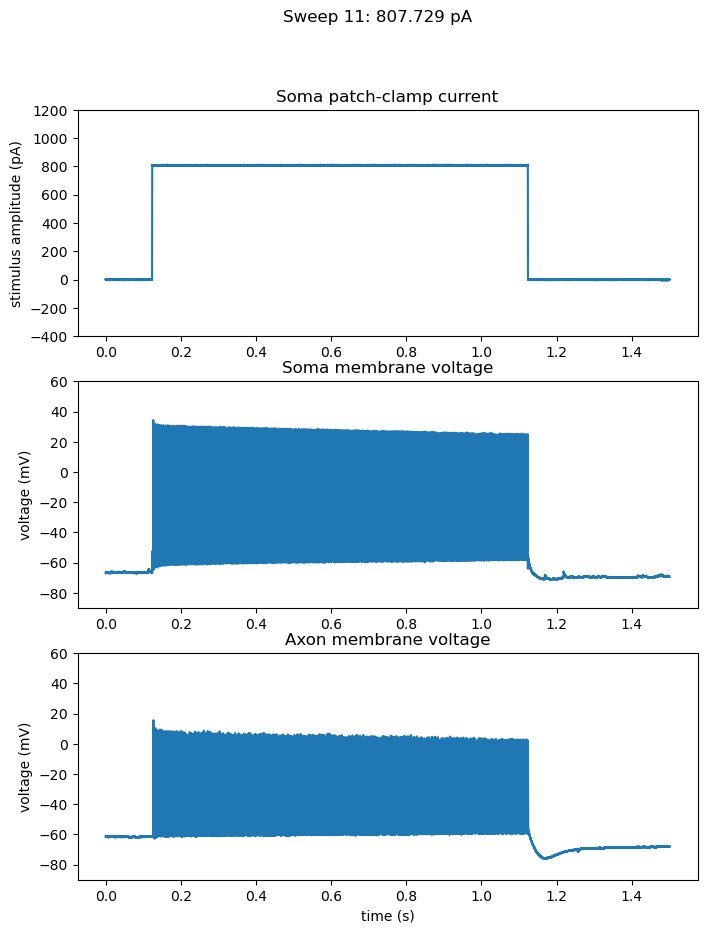

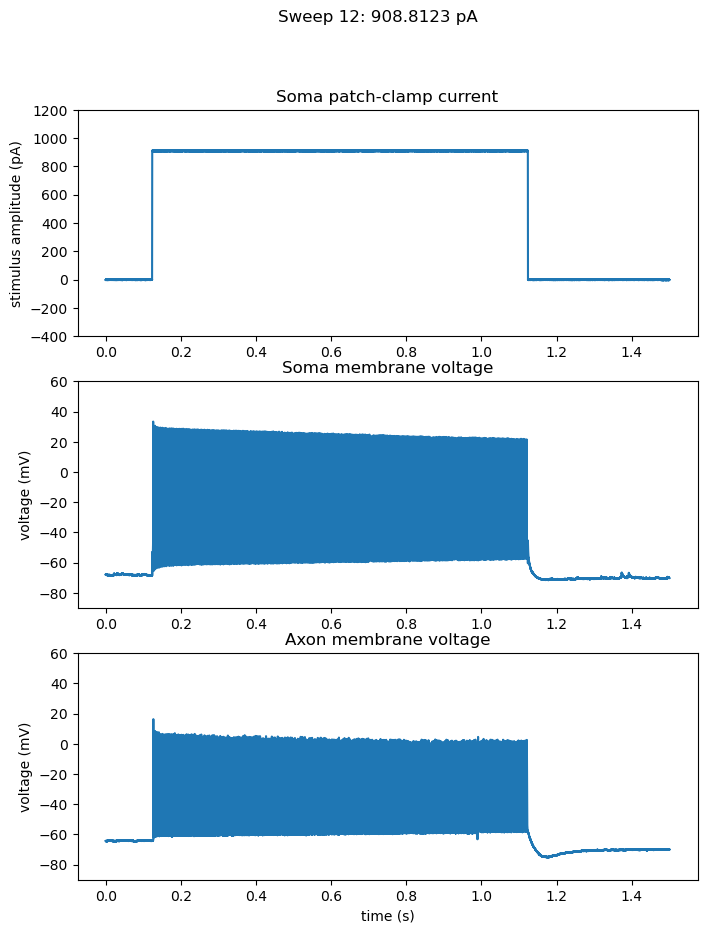

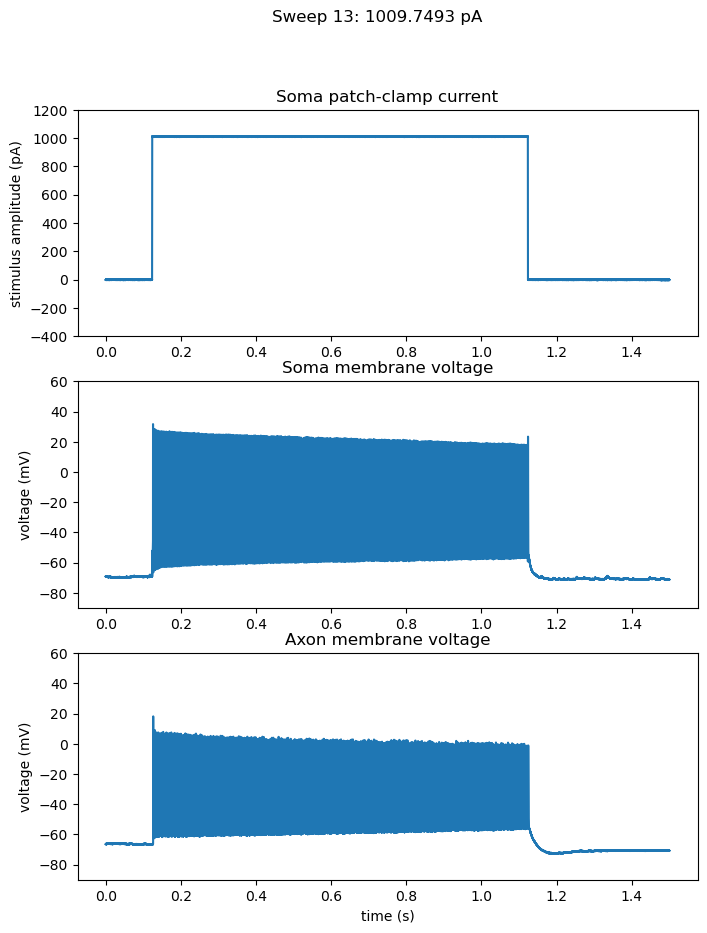

In [10]:
if plot_figures or save_figures:
    for sweep in range(num_sweeps):
        abf.setSweep(sweep, channel=abf_metadata['ch_soma_current'])
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
        ax1.plot(abf.sweepX, abf.sweepY)
        ax1.set_ylim(-400, 1200)
        ax1.set_ylabel('stimulus amplitude (pA)')
        ax1.set_title('Soma patch-clamp current')
        abf.setSweep(sweep, channel=abf_metadata['ch_soma_voltage'])
        ax2.plot(abf.sweepX, abf.sweepY)
        ax2.set_ylim(-90, 60) 
        ax2.set_ylabel('voltage (mV)')
        ax2.set_title('Soma membrane voltage')
        abf.setSweep(sweep, channel=abf_metadata['ch_axon_voltage'])
        ax3.plot(abf.sweepX, abf.sweepY)
        ax3.set_ylim(-90, 60) 
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('voltage (mV)')
        ax3.set_title('Axon membrane voltage')
        
        stim_amp = round(abf_metadata['stim_amps'][sweep]['value'], 4)
        fig_title = "Sweep " + str(sweep) + ': ' + str(stim_amp) + " pA"
        fig.suptitle(fig_title)
        if plot_figures:
            plt.show()
        if save_figures:
            path_save_fig = os.path.abspath(f"./Figures/{abf_metadata['recording_name']}/sweep_{sweep}.jpg")
            plt.savefig(path_save_fig)   
    save_figures = False
    